# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***
In this project, I used video from a camera that was mounted on a car driving down the highway. Using OpenCV, I calibrated the camera and processed each frame in order to detect lane lines. I also calculated lane curvature and vehicle offset from the lane center. The detected lane lines were then drawn onto each frame and the images were put together to form a new video identical to the original with overlays of the detected lane lines, the lane curvature, and the vehicle offset. 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


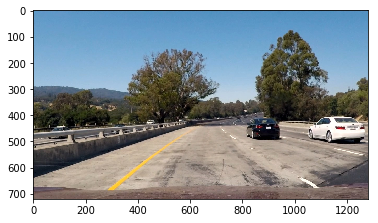

In [2]:
#reading in a test image
image = mpimg.imread('CarND-Advanced-Lane-Lines-master/test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


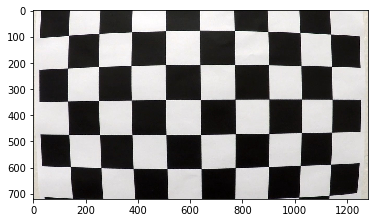

In [3]:
#reading in an image from the calibration set
image2 = mpimg.imread('CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(image2), 'with dimensions:', image2.shape)
plt.imshow(image2) 

## Calibrate Cameras

<class 'numpy.ndarray'> (45, 1, 2)


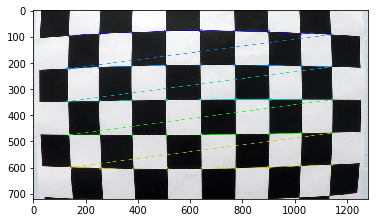

In [4]:
def find_corners(fname, nx, ny):
    '''
    Finds the inner corners of a chessboard calibration image.
    Parameters-
        fname: the name/location of the image file
        nx: number of corners expected in the horizontal direction
        ny: number of corners expected in the vertical direction
    Outputs-
        ret: boolean that signifies whether corners were selected
        corners: array of corner locations
    '''
    # Make a list of calibration images
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return ret, corners, img

nx = 9
ny = 5
fname = 'CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg'
ret, corners, img = find_corners(fname, nx, ny)
plt.imshow(img)
print(type(corners),corners.shape)

<class 'numpy.ndarray'> (54, 1, 2)


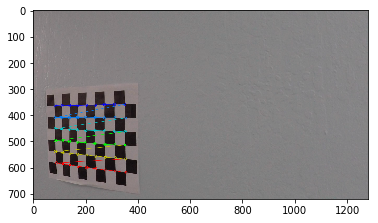

In [5]:
#Corners found on another calibration image.
nx = 9
ny = 6
fname = 'CarND-Advanced-Lane-Lines-master/camera_cal/calibration20.jpg'
ret, corners, img = find_corners(fname, nx, ny)
plt.imshow(img)
print(type(corners),corners.shape)

In [6]:
def calibrate(nx, ny):
    '''
    Calibrates a camera given a set of points detected in one or more calibration images.
    Parameters-
        nx: number of corners expected in the horizontal direction
        ny: number of corners expected in the vertical direction
    Outputs-
        ret: boolean that signifies whether corners were selected
        mtx, dist, rvecs, tvecs: outputs from OpenCV cv2.calibrateCamera() function. 
    '''
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./CarND-Advanced-Lane-Lines-master/camera_cal/cal*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        ret, corners, img = find_corners(fname, nx, ny)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    #cv2.destroyAllWindows()
    return ret, mtx, dist, rvecs, tvecs


ret, mtx, dist, rvecs, tvecs = calibrate(nx, ny)

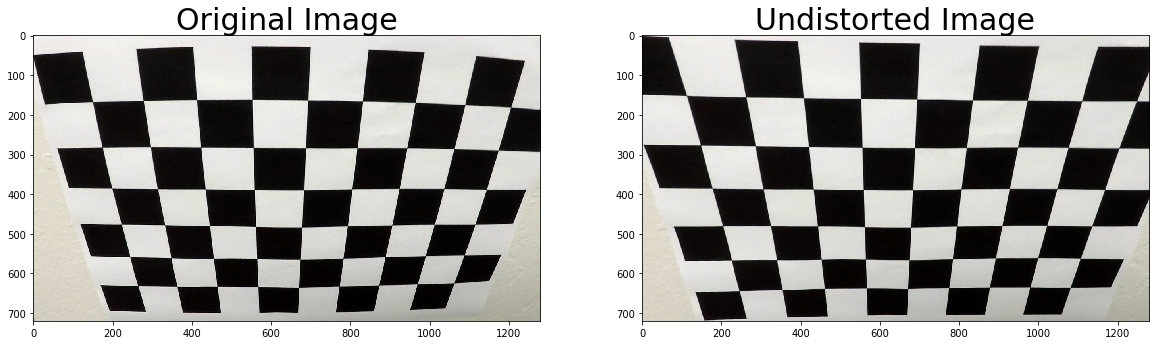

In [7]:
%matplotlib inline

#Test the results of the calibration
img_original = mpimg.imread('./CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
img_undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

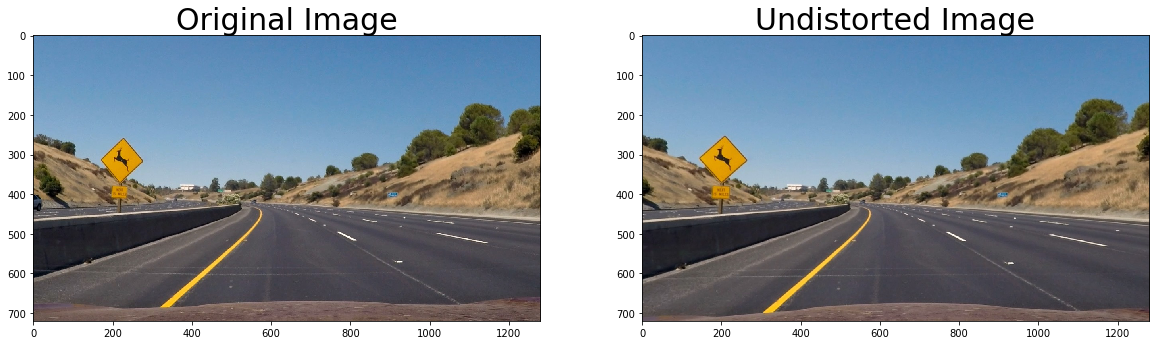

In [8]:
#Apply undistortion to actual road images
img_original = mpimg.imread('./CarND-Advanced-Lane-Lines-master/test_images/test2.jpg')
img_undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

It is difficult to see the effects of the undistortion on the real road image, but it is possible to tell that a transformation has occured by looking at the shape of the hood of the car.

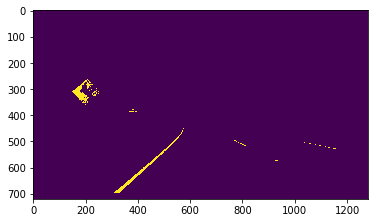

In [9]:
def binary_s_threshold(img, thresh):
    '''
    Converts 
    Parameters-
        nx: number of corners expected in the horizontal direction
        ny: number of corners expected in the vertical direction
    Outputs-
        ret: boolean that signifies whether corners were selected
        mtx, dist, rvecs, tvecs: outputs from OpenCV cv2.calibrateCamera() function. 
    '''
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 255
    return binary

s_binary = binary_s_threshold(img_undistorted, thresh = (225,255))
plt.imshow(s_binary)

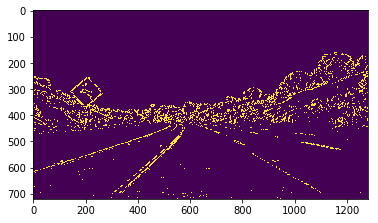

In [10]:
def sobel_x(img, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 60
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 255
    return sxbinary 
sobel_binary = sobel_x(img_undistorted, thresh = (20,100))
plt.imshow(sobel_binary)

49935
(720, 1280, 3)


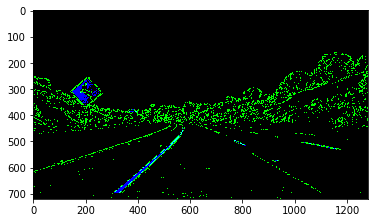

In [11]:
color_binary = np.dstack((np.zeros_like(sobel_binary), sobel_binary, s_binary))
print(np.count_nonzero(color_binary))
print(color_binary.shape)
plt.imshow(color_binary)

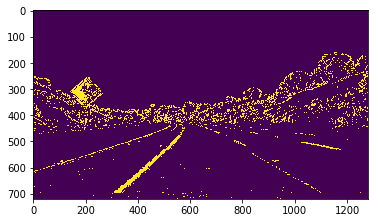

In [12]:
combined_binary = np.zeros_like(sobel_binary)
combined_binary[(s_binary == 255) | (sobel_binary == 255)] = 1
plt.imshow(combined_binary)

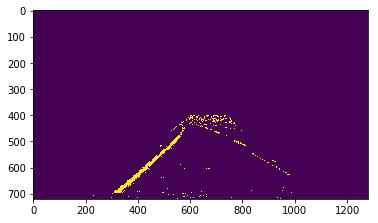

In [13]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
top_right_vertex = (740,400)
top_left_vertex = (600,400)
bottow_right_vertex = (1080,imshape[0])
bottom_left_vertex = (200,imshape[0])
vertices = np.array([[bottom_left_vertex,top_left_vertex, top_right_vertex, bottow_right_vertex]], dtype=np.int32)
cropped_combined_binary = region_of_interest(combined_binary, vertices)
plt.imshow(cropped_combined_binary)

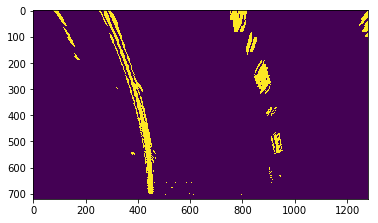

In [14]:
def perspective_transform(undistorted_image):
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[200,700],[597,450],[686,450],[1110,700]])
    dst = np.float32([[380,700],[400,0],[900,0],[921,700]])
    # Given src and dst points, calculate the perspective transform matrix
    img_size = (undistorted_image.shape[1], undistorted_image.shape[0]) 
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undistorted_image, M, img_size)

    # Return the resulting image and matrix
    return warped, M

warped, M = perspective_transform(cropped_combined_binary)
plt.imshow(warped)
#I'm not seeing much point in using the sobel at all??

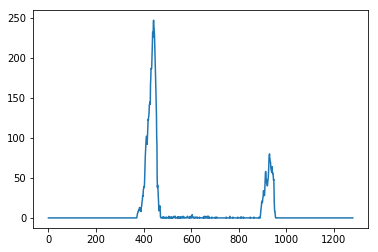

In [15]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

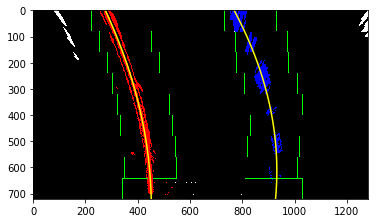

In [16]:
def sliding_window_blind(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return ploty, left_fit, right_fit, left_fitx, right_fitx, out_img
    
ploty, left_fit, right_fit, left_fitx, right_fitx, out_img = sliding_window_blind(warped)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

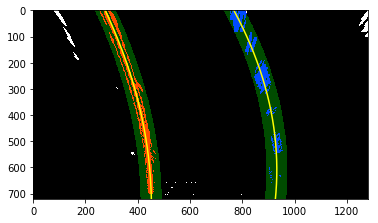

In [17]:
def neighborhood_search(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return ploty, left_fit, right_fit, left_fitx, right_fitx, result

ploty, left_fit, right_fit, left_fitx, right_fitx, out_img = neighborhood_search(warped, left_fit, right_fit)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

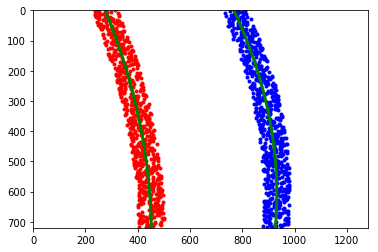

In [18]:
def fake_data_lane_lines(ploty, left_fit, right_fit):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([right_fit[0]*y**2 + right_fit[1]*y + right_fit[2] + np.random.randint(-50, high=51) for y in ploty])

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return leftx, rightx
    
leftx, rightx = fake_data_lane_lines(ploty, left_fit, right_fit)
# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [19]:
def find_curvature_and_offset(ploty, leftx, rightx, left_fit, right_fit):    
    #Find lane curvature
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    #Find offset from ceter of lane.
    vehicle_midpoint = 1280/2.
    left_intercept = left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2]
    right_intercept = right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2]
    lane_midpoint = (left_intercept + right_intercept) / 2.
    offset = (vehicle_midpoint - lane_midpoint) * xm_per_pix
    
    return left_curverad, right_curverad, offset

left_curverad, right_curverad, offset = find_curvature_and_offset(ploty, leftx, rightx, left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm', offset, 'm')

548.037833661 m 365.796053331 m -0.260761066927 m


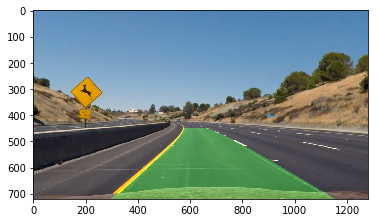

In [20]:
from numpy.linalg import inv
def draw_lines_on_unwarped(warped, ploty, left_fitx, right_fitx, M, undist):
    Minv = inv(M)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result = draw_lines_on_unwarped(warped, ploty, left_fitx, right_fitx, M, img_undistorted)

plt.imshow(result)

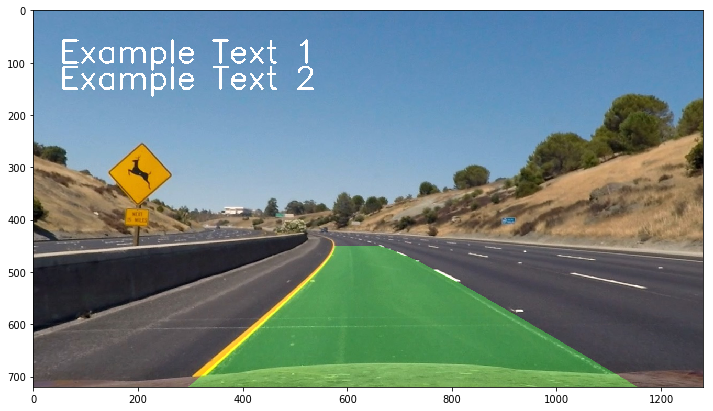

In [21]:
def print_text_on_image(img,text1,text2):
    text_image = cv2.putText(img,text1, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    text_image = cv2.putText(text_image,text2, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    return text_image
text_image = print_text_on_image(result,'Example Text 1','Example Text 2')

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

ax.imshow(text_image)

## Lines Class

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [22]:
class Frame():
    def __init__(self):
        self.number = 0
        self.left_fit_list = []
        self.right_fit_list = []
        self.curvature = 0
        self.offset = 0
        
    def next_frame(self):
        self.number += 1

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

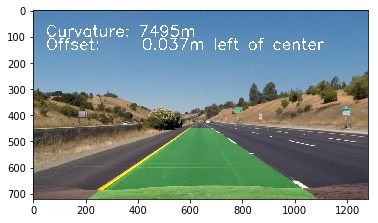

In [24]:
frame = Frame()
#PIPELINE - Each image in the video will be run through this pipline.
def process_image(image, mtx = mtx, dist = dist):
    #Distortion Correction
    img_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    #Thresholding
    s_binary = binary_s_threshold(img_undistorted, thresh = (225,255))
    sobel_binary = sobel_x(img_undistorted, thresh = (20,100))
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(s_binary == 255) | (sobel_binary == 255)] = 1
    
    #Cropping
    imshape = image.shape
    top_right_vertex = (800,400)
    top_left_vertex = (500,400)
    bottow_right_vertex = (1200,imshape[0])
    bottom_left_vertex = (80,imshape[0])
    vertices = np.array([[bottom_left_vertex,top_left_vertex, top_right_vertex, bottow_right_vertex]], dtype=np.int32)
    cropped_combined_binary = region_of_interest(combined_binary, vertices)
    
    #Perspective Transform
    warped, M = perspective_transform(cropped_combined_binary)
    
    #Determine frame
    frame.next_frame()
    #Detect Lane Lines
    if (frame.number < 4): #Only uses blind function the first time.
        ploty, left_fit, right_fit, left_fitx, right_fitx, _ = sliding_window_blind(warped)
        frame.left_fit_list.append(left_fit)
        frame.right_fit_list.append(right_fit)
    else:
        #average the last three lines
        left_fit = np.mean( np.array([ frame.left_fit_list[-3:-2],frame.left_fit_list[-2:-1],frame.left_fit_list[-1:]]), axis=0 )
        right_fit = np.mean( np.array([ frame.right_fit_list[-3:-2],frame.right_fit_list[-2:-1],frame.right_fit_list[-1:]]), axis=0 )
        left_fit = left_fit[0]
        right_fit = right_fit[0]
        ploty, left_fit, right_fit, left_fitx, right_fitx, result = neighborhood_search(warped, left_fit, right_fit)
        frame.left_fit_list.append(left_fit)
        frame.right_fit_list.append(right_fit)
        
    #Determine Curvature and Lane Center Offset
    curvature = frame.curvature
    offset = frame.offset
    if(frame.number % 9 == 0 or frame.number == 1):
        leftx, rightx = fake_data_lane_lines(ploty, left_fit, right_fit)
        left_curverad, right_curverad, offset = find_curvature_and_offset(ploty, leftx, rightx, left_fit, right_fit)
        curvature = int((left_curverad + right_curverad) / 2.)
        frame.curvature = curvature
        frame.offset = offset

    #Draw Lane Lines
    lines_drawn = draw_lines_on_unwarped(warped, ploty, left_fitx, right_fitx, M, image)
    
    
    #Print text on Image
    text1 = 'Curvature: '+str(curvature)+'m' 
    if (offset < 0):
        text2 = 'Offset: '+"{:9.3f}".format(-offset)+'m left of center'
    else:
        text2 = 'Offset: '+"{:9.3f}".format(offset)+'m right of center'
    
    result = print_text_on_image(lines_drawn,text1,text2)
    
    return result

image = mpimg.imread('./CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')
result = process_image(image, mtx, dist)
plt.imshow(result)

In [25]:
import imageio
imageio.plugins.ffmpeg.download()

In [26]:
frame = Frame()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#Create new video
white_output = './CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4'
clip1 = VideoFileClip('./CarND-Advanced-Lane-Lines-master/project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4
[MoviePy] Writing video ./CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [03:06<00:00,  6.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./CarND-Advanced-Lane-Lines-master/output_videos/project_video.mp4 

CPU times: user 4min 25s, sys: 1min 7s, total: 5min 32s
Wall time: 3min 7s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))